In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC as SupportVectorClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from keras.optimizers import Adam, Nadam, Adamax, Adadelta, Adagrad
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow_addons.activations import mish
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import sys
import re
import numpy as np
import pandas as pd
import random
import contractions
import seaborn as sns
import matplotlib.pyplot as plt

from collections import deque, Counter
from itertools import permutations, repeat, combinations

In [2]:
empires = []
vectorizer = CountVectorizer()
min_sentence_length = 5

In [3]:
with open("Resources/Data/EmpireText.txt", "r", encoding="utf8") as file:
    line = file.readline().replace("\n", "").split(" ")
    for empire in line:
        empires.append(empire)

In [4]:
def format_sentence(sentence, current_empire):
        if len(sentence.split(" ")) > min_sentence_length:
            sentence = contractions.fix(sentence)
            contains_other_empire = False
            for empire in empires:
                if empire == current_empire:
                    continue
                elif re.search(empire.lower(), sentence.lower()) is not None:
                    contains_other_empire = True

            if not contains_other_empire:
                return sentence.strip()

text = []
labels = []
with open("Resources/Data/EmpireText.txt", "r", encoding="utf8") as file: 
    for line in file.readlines()[1:]:
        line = line.strip()
        line = line.replace("\n", "")
        line = re.sub("\[.{0,4}]", "", line) 
        line = line.replace("C.", "C")
        line = line.replace("E.", "E")
        line = line.replace("D.", "D")
        
        if line in empires:
            current_empire = line
            continue
        elif len(line.replace(" ", "")) < min_sentence_length:
            continue
        elif len(line.split(" ")) < min_sentence_length:
            continue
        elif line[-1] != ".":
            line += "."
    
        line = nltk.sent_tokenize(line)
        for sentence in line:
            sentence = format_sentence(sentence, current_empire)
            if sentence is not None:
                text.append(sentence)
                labels.append(current_empire)
            
data = pd.DataFrame({"label":labels, "text":text})

# Data Visualization

## Training Data

In [5]:
data.head()

,label,text
0,Roman,"The Roman Empire, the ancient empire, centred ..."
1,Spanish,The Spanish Empire (Spanish: Imperio españold)...
2,Russian,"The Russian Empire, also known as Imperial Rus..."
3,Roman,A period of unrest and civil wars in the 1st c...
4,Roman,This period encompassed the career of Julius C...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3169 non-null   object
 1   text    3169 non-null   object
dtypes: object(2)
memory usage: 49.6+ KB


In [7]:
training_value_counts = data["label"].value_counts()
training_value_counts

Roman      1254
Russian    1004
Spanish     911
Name: label, dtype: int64

# Text classification:
### The process of text classification is comprised of 4 main steps
#### - Preprocessing the text
#### - Encoding labels
#### - Vectorizing the text
#### - Training the model(s)
***

## Text preprocessing
### Steps:
- Lowercasing
- Tokenization
- POS tagging
- Lemmatization

Note: When tested, the models showed better results without the removal of stopwords

### Example:

In [8]:
example_paragraph = data['text'][1]
example_paragraph = "".join(example_paragraph)
print(data['label'][1], "empire:")
example_paragraph

Spanish empire:


'The Spanish Empire (Spanish: Imperio españold), also known as the Hispanic Monarchy (Spanish: Monarquía Hispánica) or the Catholic Monarchy (Spanish: Monarquía Católica) was a colonial empire governed by Spain and its predecessor states between 1492 and 1976.'

In [9]:
lowercase_paragraph = example_paragraph.lower()
lowercase_paragraph

'the spanish empire (spanish: imperio españold), also known as the hispanic monarchy (spanish: monarquía hispánica) or the catholic monarchy (spanish: monarquía católica) was a colonial empire governed by spain and its predecessor states between 1492 and 1976.'

In [10]:
tokenized_paragraph = nltk.word_tokenize(lowercase_paragraph)
for word in tokenized_paragraph:
    print(f"'{word}'", end=", ")

'the', 'spanish', 'empire', '(', 'spanish', ':', 'imperio', 'españold', ')', ',', 'also', 'known', 'as', 'the', 'hispanic', 'monarchy', '(', 'spanish', ':', 'monarquía', 'hispánica', ')', 'or', 'the', 'catholic', 'monarchy', '(', 'spanish', ':', 'monarquía', 'católica', ')', 'was', 'a', 'colonial', 'empire', 'governed', 'by', 'spain', 'and', 'its', 'predecessor', 'states', 'between', '1492', 'and', '1976', '.', 

In [11]:
tagged_paragraph = nltk.pos_tag(tokenized_paragraph)
for word in tagged_paragraph:
    print(word, end=', ')

('the', 'DT'), ('spanish', 'JJ'), ('empire', 'NN'), ('(', '('), ('spanish', 'JJ'), (':', ':'), ('imperio', 'NN'), ('españold', 'NN'), (')', ')'), (',', ','), ('also', 'RB'), ('known', 'VBN'), ('as', 'IN'), ('the', 'DT'), ('hispanic', 'JJ'), ('monarchy', 'NN'), ('(', '('), ('spanish', 'JJ'), (':', ':'), ('monarquía', 'NN'), ('hispánica', 'NN'), (')', ')'), ('or', 'CC'), ('the', 'DT'), ('catholic', 'JJ'), ('monarchy', 'NN'), ('(', '('), ('spanish', 'JJ'), (':', ':'), ('monarquía', 'NN'), ('católica', 'NN'), (')', ')'), ('was', 'VBD'), ('a', 'DT'), ('colonial', 'JJ'), ('empire', 'NN'), ('governed', 'VBN'), ('by', 'IN'), ('spain', 'NN'), ('and', 'CC'), ('its', 'PRP$'), ('predecessor', 'NN'), ('states', 'NNS'), ('between', 'IN'), ('1492', 'CD'), ('and', 'CC'), ('1976', 'CD'), ('.', '.'), 

In [12]:
def get_pos(tag):    
    if tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN
        
wnl = WordNetLemmatizer()
lemmatized_sentence = [wnl.lemmatize(word, get_pos(pos)) for word, pos in tagged_paragraph]
for word in lemmatized_sentence:
    print(f"'{word}'", end=", ")

'the', 'spanish', 'empire', '(', 'spanish', ':', 'imperio', 'españold', ')', ',', 'also', 'know', 'a', 'the', 'hispanic', 'monarchy', '(', 'spanish', ':', 'monarquía', 'hispánica', ')', 'or', 'the', 'catholic', 'monarchy', '(', 'spanish', ':', 'monarquía', 'católica', ')', 'be', 'a', 'colonial', 'empire', 'govern', 'by', 'spain', 'and', 'it', 'predecessor', 'state', 'between', '1492', 'and', '1976', '.', 

### Application

In [13]:
sentences = []
labels = []
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
for row in data.iterrows():
    label = row[1]['label']
    text = row[1]['text']
    text = nltk.word_tokenize(text)
    text = [w.lower() for w in text if not w.lower() in stop_words]
    text = nltk.pos_tag(text)
    text = [wnl.lemmatize(word, get_pos(pos)) for word, pos in text]
    sentences.append(text)
    labels.append(label)

preprocessed_data = pd.DataFrame({"label":labels, "text":sentences})

In [14]:
preprocessed_data.head()

,label,text
0,Roman,"[roman, empire, ,, ancient, empire, ,, centre,..."
1,Spanish,"[spanish, empire, (, spanish, :, imperio, espa..."
2,Russian,"[russian, empire, ,, also, know, imperial, rus..."
3,Roman,"[period, unrest, civil, war, 1st, century, bce..."
4,Roman,"[period, encompass, career, julius, caesar, ,,..."


## Label Encoding

In [15]:
labels = []
for label in preprocessed_data['label']:
    labels.append(empires.index(label))
preprocessed_data['label'] = labels

In [16]:
preprocessed_data.head()

,label,text
0,0,"[roman, empire, ,, ancient, empire, ,, centre,..."
1,1,"[spanish, empire, (, spanish, :, imperio, espa..."
2,2,"[russian, empire, ,, also, know, imperial, rus..."
3,0,"[period, unrest, civil, war, 1st, century, bce..."
4,0,"[period, encompass, career, julius, caesar, ,,..."


## Text Vectorization

In [17]:
vectorizer = CountVectorizer()
text = []
for sentence in preprocessed_data['text']:
    text.append(" ".join(sentence))
vectorizer.fit(text)
vectorized_text = vectorizer.transform(text)

## Training the models

In [18]:
def get_unique_words(data):
        unique_words = set()
        print("len", len(data))
        for sentence in data:
                for word in sentence:
                    unique_words.add(word)
        return len(unique_words)
num_uniques = get_unique_words(preprocessed_data['text'])

len 3169


In [19]:
text = vectorized_text
labels = preprocessed_data['label']
x_train, x_test, y_train, y_test = train_test_split(text, labels, test_size=.1, random_state=0)

#### Decision Tree

In [20]:
decision_tree = DecisionTreeClassifier(random_state=2, max_depth=150, max_features=1000)
decision_tree.fit(x_train, y_train)
decision_tree_score = decision_tree.score(x_test, y_test)*100
decision_tree_score

85.8044164037855

#### Random Forest

In [21]:
random_forest = RandomForestClassifier(random_state=0, n_estimators=300, max_depth=150, max_features=1000)
random_forest.fit(x_train, y_train)
random_forest_score = random_forest.score(x_test, y_test)*100
random_forest_score

89.27444794952682

#### Support Vector Machine

In [22]:
best_c = 0.1
best_kernel = "linear"
support_vector_machine = SupportVectorClassifier(kernel=best_kernel, C=best_c)
support_vector_machine.fit(x_train, y_train)
support_vector_machine_score = support_vector_machine.score(x_test, y_test)*100
support_vector_machine_score

89.58990536277602

### Long Short Term Memory

Sidenote: while one could convert x_Train from SparseTensor to array it causes the lstm model to have low accuracy and take 20 min per epoch, so its better to just format the data with tensorflow methods to convert it to a format that tensorflow is better equipped to handle.

In [23]:
text = preprocessed_data['text']
labels = preprocessed_data['label']
longest_sentence = max(text, key=lambda x: len(x))
encoded_sentences = [one_hot(" ".join(sentence), num_uniques) for sentence in text]
padded_sequences = pad_sequences(encoded_sentences, maxlen=len(longest_sentence), padding='post')

def encode_labels(labels):
    output = []
    for label in labels:
        label_array = np.zeros(len(empires))
        label_array[label] = 1    
        output.append(label_array)
    return output

labels = encode_labels(labels)
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, train_size=.66, random_state=42)
print("input example:", x_train[0])
print("label example:", y_train[0])

input example: [5944 4688 2229 6791 6113 7260 4041 2362 2580 2628 8305 2410 7457 4688
 8379 6791 6113 4588 6531 3166    1 3172   36    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
label example: [1. 0. 0.]


In [24]:
lstm = Sequential()
lstm.add(Embedding(num_uniques, 128))
lstm.add(Bidirectional(LSTM(64)))
lstm.add(Dense(256, activation="relu"))
lstm.add(Dropout(0.5))
lstm.add(Dense(128))
lstm.add(Dense(3, activation="sigmoid"))
lstm.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1152896   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 3)                 387       
                                                        

In [25]:
lstm.fit(np.array(x_train), np.array(y_train), epochs=5, verbose=1, batch_size=128, callbacks=[])

Epoch 1/5
17/17 [==============================] - 4s 91ms/step - loss: 1.0813 - accuracy: 0.3893
Epoch 2/5
17/17 [==============================] - 2s 91ms/step - loss: 0.6996 - accuracy: 0.7982
Epoch 3/5
17/17 [==============================] - 2s 95ms/step - loss: 0.1270 - accuracy: 0.9665
Epoch 4/5
17/17 [==============================] - 2s 93ms/step - loss: 0.0288 - accuracy: 0.9914
Epoch 5/5
17/17 [==============================] - 2s 91ms/step - loss: 0.0061 - accuracy: 0.9995


In [26]:
lstm_score = lstm.evaluate(x_test, np.array(y_test), verbose=1)
lstm_score = lstm_score[1]*100
print(f'Test accuracy: {lstm_score}')

34/34 [==============================] - 1s 9ms/step - loss: 0.2684 - accuracy: 0.9230
Test accuracy: 92.30055809020996


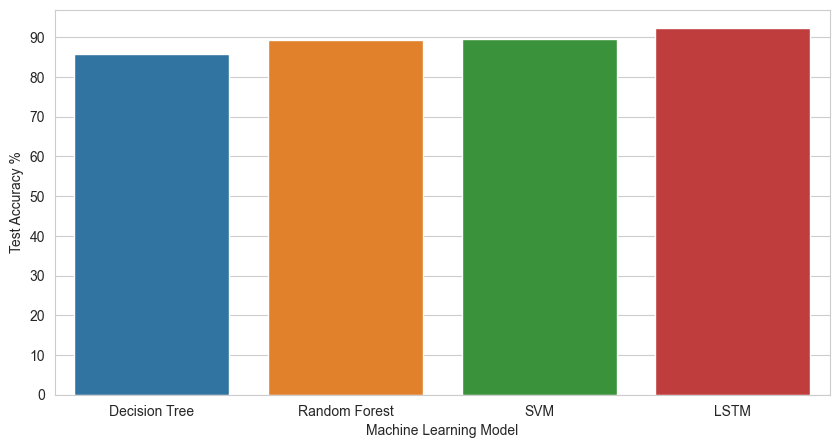

In [27]:
models = ['Decision Tree', 'Random Forest', 'SVM', 'LSTM']
accuracies = [decision_tree_score, random_forest_score, support_vector_machine_score, lstm_score]

sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Test Accuracy %")
plt.xlabel("Machine Learning Model")
sns.barplot(x=models, y=accuracies)
plt.show()